In [5]:
temp_dir = "/Users/alexbindas/tmp"
json_directory_path = "../data/raw_data_104.tar.gz"

In [ ]:
import shutil
shutil.rmtree(temp_dir)

In [6]:
import tarfile
import os
import shutil
import structlog
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, expr, when, udf, explode_outer, collect_list
from pyspark.sql.types import IntegerType, StringType, ArrayType, StructType, StructField, FloatType
from datetime import datetime

logger = structlog.get_logger()


# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Process JSON Files") \
    .getOrCreate()

# Read all JSON files from a directory
os.makedirs(temp_dir, exist_ok=True)

def extract_and_read_tar_gz(file_path):
    # Create a temporary directory to store extracted files
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=temp_dir)
    # Read all JSON files from the temporary directory
    json_df = spark.read.json(f"{temp_dir}/*.json", multiLine=True)
    return json_df

df = extract_and_read_tar_gz(json_directory_path)
df.cache()
logger.info("Dataframe initialized successfully.", json_directory_path=json_directory_path, count=df.count())
rdd = df.rdd


24/04/25 17:02:23 WARN Utils: Your hostname, Alexandrias-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.239.74.97 instead (on interface en0)
24/04/25 17:02:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/25 17:02:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/25 17:02:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


2024-04-25 17:03:14 [info     ] Dataframe initialized successfully. count=3326 json_directory_path=../data/raw_data_104.tar.gz


In [7]:
df.printSchema()

root
 |-- activity: struct (nullable = true)
 |    |-- connections: string (nullable = true)
 |    |-- followers: string (nullable = true)
 |-- education: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- dates_attended: struct (nullable = true)
 |    |    |    |-- end: string (nullable = true)
 |    |    |    |-- start: string (nullable = true)
 |    |    |    |-- total_time: string (nullable = true)
 |    |    |-- degree: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |-- school_name: string (nullable = true)
 |-- education_count: long (nullable = true)
 |-- experience_count: long (nullable = true)
 |-- experiences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- company_name: string (nullable = true)
 |    |    |-- positions: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = t

In [8]:
pandas_df = df.toPandas()
pandas_df.head()

,activity,education,education_count,experience_count,experiences,id,last_generated_at,skills,skills_count
0,"(500+, 725)","[((2024, 2019, None), [['Doctor of Philosophy ...",3,17,[(Stanford University Graduate School of Educa...,e380dd9b-96d5-dc37-9748-e27ddf92e329,"April 24, 2024, 10:26 PM",[],0
1,"(500+, 1K)","[((2025, 2024, None), [['Master of Science - M...",4,13,"[(Amazon, [Row(description='Summer 2024', end=...",8ba35d46-21dc-f6bf-5d41-576d1f187003,"April 22, 2024, 08:21 PM",[],0
2,"(500+, 886)","[(None, [['Doctor of Philosophy (PhD)', 'Biome...",4,8,"[(Publicis Groupe, [Row(description=None, end=...",ff31aa7e-7682-74ec-6dbe-8f6348ebfbb8,"April 22, 2024, 08:43 PM",[],0
3,"(500+, None)","[((2023, 2021, None), [['Master of Public Heal...",4,18,[(Yale Program on Climate Change Communication...,7657427a-3bc6-bda4-55dc-2c522bd2cf45,"April 22, 2024, 08:43 PM",[],0
4,"(500+, 2K)","[((1979, 1973, None), [['Ph.D.', 'Mathematics,...",1,18,"[(University of Massachusetts Amherst, [Row(de...",01c697ec-5f1f-4712-8ece-2107ac3be81e,"April 22, 2024, 11:20 PM",[],0


In [9]:
import re

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, expr, when, udf
from pyspark.sql.types import IntegerType, StringType, ArrayType, FloatType
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

# -- Common --
def get_average_of_list(arr):
    if arr and len(arr) > 0:
        return float(np.mean(arr))
    else:
        return 0

def convert_to_std_date(date_str):
    '''
    Converts std to a date string by exatracting the year and month
    '''
    if date_str is None:
        return None

    try:
        date_obj = datetime.strptime(date_str, "%b %Y")
    except ValueError:
        try:
            # Handle the case where only the year is provided
            date_obj = datetime.strptime(date_str, "%Y")
        except ValueError:
            return None

    standard_date = date_obj.strftime("%Y-%m-%d")
    return standard_date

def convert_text_to_number(s: str):
    '''
    Converts the text for followers and connections to a number,
    extracting the values out.
    '''
    if s is None:
        return 0
    try:
        s = s.strip().replace(',', '')
        if 'K' in s:
            s = s.replace('K', '')
            return int(float(s) * 1000)
        if 'M' in s:
            s = s.replace('M', '')
            return int(float(s) * 1000000)
        elif '+' in s:
            s = s.replace('+', '')
            return int(s)
    except ValueError:
        return 0
    return int(s)



# -- Education --
education_level_mapping = {
    'high school': 1,
    'certificate': 2,
    'associate': 3,
    'bachelor': 4,
    'master':5,
    'PhD': 6,
}
education_level_mapping_to_string = {v: k for k, v in education_level_mapping.items()}
def clean_degree_level(education) -> str| int:
    if not education:
        return None
    degree_list = education.degree[0]
    if not degree_list:
        return None
    degree = degree_list[0]
    degree = degree.strip().lower()
    school_name = education.school_name.strip().lower()
    if "high school" in school_name:
        # return 'high school diploma'
        return education_level_mapping.get("high school")
    if any([d in degree for d in ["master of science", "master", "ms", "m.s", "m.a.", "ma"]]):
        # return "master"
        return education_level_mapping.get("master")
    elif any([d in degree for d in ['doctor', 'phd']]):
        # return "PhD"
        return education_level_mapping.get("PhD")
        # return 5
    elif any([d in degree for d in ['bs', 'b.s', 'bachelor', 'b.a', 'ba', 'undergraduate']]):
        # return "bachelor"
        return education_level_mapping.get("bachelor")
    elif any([d in degree for d in ["associate's", "associate"]]):
    #   return "associate"
        return education_level_mapping.get("associate")
    elif any([d in degree for d in ["cert"]]):
        # return "certificate"
        return education_level_mapping.get("certificate")
    return 0

def clean_major(degree_list):
    '''
    Returns the major cleaned string
    '''
    if not degree_list:
        return 0
    major = degree_list.pop(-1)
    if any(char.isnumeric() for char in major):
        return 0
    return major


school_name_mapping = {}
school_name_mapping_to_string = {v: k for k, v in school_name_mapping.items()}
def get_clean_school_names(education):
    '''
    Clean school name and maps to an int
    '''
    if not education:
        return None
    school_names = []
    for edu in education:
        school_name = edu.school_name.strip().lower()
        clean_school_name = None
        if school_name == 'mit' or any([s in school_name for s in [
            'massachusetts institute of technology']]):
            clean_school_name = 'massachusetts institute of technology (mit)'
        elif any([s in school_name for s in ['california institute of technology', 'caltech']]):
            clean_school_name = "california institute of technology"
        elif any([s in school_name for s in ['standford', 'standford university']]):
            clean_school_name = "standford"
        elif any([s in school_name for s in ['carneigie mellon', 'carneigie']]):
            clean_school_name = "carneigie mellon"
        elif any([s in school_name for s in ['harvard', 'harvard university']]):
            clean_school_name = "harvard"
        elif any([s in school_name for s in ['yale', 'yale university']]):
            clean_school_name = "yale"
        elif any([s in school_name for s in ['columbia university']]):
            clean_school_name = "columbia university"
        elif any([s in school_name for s in ['princeton', 'princeton university']]):
            clean_school_name = "princeton university"
        elif any([s in school_name for s in ['georgia tech', 'georgia institute of technology']]):
            clean_school_name = "georgia institute of technology"
        elif any([s in school_name for s in ['brown', 'brown university']]):
            clean_school_name = "brown university"
        elif any([s in school_name for s in ['university of southern california']]):
            clean_school_name = "university of southern california"
        elif any([s in school_name for s in ['boston university', 'boston university metropolitan college']]):
            clean_school_name = "boston university"
        elif any([s in school_name for s in ['boston college', 'bc']]):
            clean_school_name = "boston college"
        elif any([s in school_name for s in ['university of massachusetts amherst', 'umass amherst']]):
            clean_school_name = "university of massachusetts amherst"
        elif any([s in school_name for s in ['northeastern university', 'northeastern']]):
            clean_school_name = "northeastern university"
        elif any([s in school_name for s in ['tufts university', 'tufts']]):
            clean_school_name = "tufts university"
        elif any([s in school_name for s in ['wpi', 'worcester polytech institute']]):
            clean_school_name = "worcester polytech institute"
        elif any([s in school_name for s in ['umass lowell', 'university of massachusetts lowell']]):
            clean_school_name = "university of massachusetts lowell"
        elif any([s in school_name for s in ['umass boston', 'university of massachusetts boston']]):
            clean_school_name = "university of massachusetts boston"
        elif any([s in school_name for s in ['babson college', 'babson']]):
            clean_school_name = "babson college"
        elif any([s in school_name for s in ['brandeis']]):
            clean_school_name = "brandeis"
        elif any([s in school_name for s in ['wentworth']]):
            clean_school_name = "wentworth"
        elif any([s in school_name for s in ['state university', 'state college']]):
            clean_school_name = "* state university"
        else:
            clean_school_name = None
        school_names.append(clean_school_name)
    return school_names

def get_degree_levels_list(education_list):
    if not education_list:
        return None
    degree_levels = []
    for _education_item in list(education_list):
        if not _education_item:
            continue
        degree_level = clean_degree_level(_education_item)
        degree_levels.append(degree_level)
    return degree_levels

def get_bs_school_name(education_list):
    if not education_list:
        return None
    school_names = get_clean_school_names(education_list)
    degree_levels = get_degree_levels_list(education_list)
    for i, degree in enumerate(degree_levels):
        if degree == education_level_mapping.get("bachelor"):
            return school_names[i]
    return None

def get_ms_school_name(education_list):
    if not education_list:
        return None
    school_names = get_clean_school_names(education_list)
    degree_levels = get_degree_levels_list(education_list)
    for i, degree in enumerate(degree_levels):
        if degree == education_level_mapping.get("master"):
            return school_names[i]
    return None

def get_phd_school_name(education_list):
    if not education_list:
        return None
    school_names = get_clean_school_names(education_list)
    degree_levels = get_degree_levels_list(education_list)
    for i, degree in enumerate(degree_levels):
        if degree == education_level_mapping.get("PhD"):
            return school_names[i]
    return None


def get_total_time_to_graduate(education_list):
    if not education_list:
        return None
    total_time_list = []
    for education in education_list:
        # Extract data from dates_attended
        end_year = None
        start_year = None
        total_years_to_complete = None
        if education.dates_attended:
            # Extract data from dates_attended
            end_year = education.dates_attended.end
            start_year = education.dates_attended.start
            try:
                if end_year and start_year:
                    total_years_to_complete = int(end_year) - int(start_year)
            except ValueError:
                print("Invalid type", education.dates_attended)
        total_time_list.append(total_years_to_complete)
    return total_time_list


def has_phd(degree_levels):
    '''
    Return 1 for phd, 0 for no phd
    '''
    if not degree_levels:
        return 0
    if education_level_mapping.get("PhD") in degree_levels:
        return 1
    return 0

def has_ms(degree_levels):
    '''
    Return 1 for ms, 0 for no ms
    '''
    if not degree_levels:
        return 0
    if education_level_mapping.get("master") in degree_levels:
        return 1
    return 0

# -- Experience --
job_level_mapping = {
    'student': 1,
    'tutor': 2,
    'TA': 3,
    'research assistant': 4,
    'intern': 5,
    'entry level': 6,
    'mid level': 7,
    'senior': 8,
    'lead/manager': 9,
    'director/vp': 10,
    'ceo/founder/president': 11,
    'consultant': 0
}
job_level_mapping_to_string = {
    v: k for k, v in job_level_mapping.items()
}
def clean_job_level(position) -> str:
    if not position:
        return None
    job_title = position.job_title.strip().lower()
    if "intern" in job_title:
        return job_level_mapping.get('intern')
    elif any([t in job_title for t in ["student"]]):
        return job_level_mapping.get('student')
    elif job_title == 'ta' or any([t in job_title for t in [
        "teacher's assistant", "course assistant",
        'teacher assistant', "teaching assistant",
        'teachers assistant', "learning assistant"]]):
        return job_level_mapping.get('TA')
    elif any([t in job_title for t in ["research assistant"]]):
        return job_level_mapping.get('research assistant')
    elif any([t in job_title for t in ["jr.", "junior", 'entry', 'associate']]):
        return job_level_mapping.get('entry level')
    elif any([t in job_title for t in ["senior", 'sr.']]):
        return job_level_mapping.get('senior')
    elif any([t in job_title for t in ["director", 'vp', 'vice president', "chief", "cto"]]):
        return job_level_mapping.get('director/vp/chief/cto')
    elif any([t in job_title for t in ["tutor"]]):
        return job_level_mapping.get('tutor')
    elif any([t in job_title for t in ["consultant", "contractor"]]):
        return job_level_mapping.get('consultant')
    elif any([t in job_title for t in ["co-founder", 'founder', 'ceo', 'president']]):
        return job_level_mapping.get("ceo/founder/president")
    elif any([t in job_title for t in ["manager", "lead"]]):
        return job_level_mapping.get("lead/manager")
    return
    # return f"not_classified"

def get_position_levels_list(experience_list):
    if not experience_list:
        return 0
    positions = []
    for i, experience in enumerate(experience_list):
        if not experience:
            continue
        for position in experience.positions:
            job_level = clean_job_level(position)
            if job_level:
                positions.append(job_level)
            else:
                positions.append(0)
    return positions

def get_position_start_dates(experience_list):
    if not experience_list:
        return None
    position_dates = []
    for i, experience in enumerate(list(experience_list)):
        if not experience:
            continue
        for position in experience.positions:
            if "year" not in position and "month" not in position:
                position_dates.append(position.start)
    return position_dates

def get_position_end_dates(experience_list):
    if not experience_list:
        return None
    position_dates = []
    for i, experience in enumerate(list(experience_list)):
        if not experience:
            continue
        for position in experience.positions:
            position_dates.append(position.end)
    return position_dates

def get_position_description(experience_list):
    if not experience_list:
            return None
    position_descriptions = []
    for i, experience in enumerate(list(experience_list)):
        if not experience:
            continue
        for position in experience.positions:
            if hasattr(position, "description"):
                position_descriptions.append(position.description)
            else:
                position_descriptions.append(None)
    return position_descriptions

def get_position_counts(experience_list):
    if not experience_list:
        return []
    position_counts = []
    for experience in list(experience_list):
        if not experience:
            continue
        count = 0
        for position in experience.positions:
            count += 1
        position_counts.append(count)
    return position_counts

def convert_to_months(duration_string):
    # Regular expressions to find years and months in the string
    years_regex = r'(\d+)\s*years?'
    months_regex = r'(\d+)\s*months?'

    # Find years and months in the duration string
    years_match = re.search(years_regex, duration_string)
    months_match = re.search(months_regex, duration_string)

    # Extract the number of years and months from the matches
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0

    # Convert the duration to months (add years converted to months)
    total_months = years * 12 + months
    return total_months

def calculate_months_between_dates(start_date_str, end_date_str):
    try:
        # Parse the start and end dates
        start_date = datetime.strptime(start_date_str, '%b %Y')
        end_date = datetime.strptime(end_date_str, '%b %Y')

        # Calculate the duration in months
        duration = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
        return max(duration, 0)
    except ValueError as e:
        print(f"Error calculating duration: {e}")
        return None

# Function to calculate total time given lists of start and end dates
def calculate_months_in_position(experience_list):
    if not experience_list:
        return None
    total_times = []
    start_dates = get_position_start_dates(experience_list)
    end_dates = get_position_end_dates(experience_list)

    for experience in list(experience_list):
        if not experience:
            continue
        for i, position in enumerate(experience.positions):
            if position.total_duration:
                duration = convert_to_months(position.total_duration)
                total_times.append(duration)
            else:
                start_date = start_dates[i] if start_dates else None
                end_date = end_dates[i] if end_dates else None
                if start_date is None and end_date is None:
                    total_times.append(0)
                elif start_date and ("year" in start_date or "month" in start_date):
                    duration = convert_to_months(start_date)
                    total_times.append(duration)
                elif end_date and ("year" in end_date or "month" in end_date):
                    duration = convert_to_months(end_date)
                    total_times.append(duration)
                else:
                    duration = calculate_months_between_dates(start_date, end_date)
                    total_times.append(duration)
    return total_times

def is_vp_ceo_founder_president(position_levels):
    '''
    Returns 0 if never having a level 9 or 10 position (ceo, vp, director)
    Otherwise, returns 1
    '''
    if not position_levels:
        return 0
    if (9 in position_levels) or (10 in position_levels):
        return 1
    return 0


# Register the UDFs
calculate_months_in_position_udf = udf(calculate_months_in_position, ArrayType(IntegerType()))
clean_major_udf = udf(clean_major)
clean_degree_level_udf = udf(clean_degree_level, StringType())
convert_to_std_date_udf = udf(convert_to_std_date, StringType())
convert_text_to_number_udf = udf(convert_text_to_number, IntegerType())
get_degree_levels_list_udf = udf(get_degree_levels_list, ArrayType(IntegerType()))
get_position_levels_list_udf = udf(get_position_levels_list, ArrayType(IntegerType()))
get_total_time_to_graduate_udf = udf(get_total_time_to_graduate, ArrayType(StringType()))
get_position_start_dates_udf = udf(get_position_start_dates, ArrayType(StringType()))
get_position_end_dates_udf = udf(get_position_end_dates, ArrayType(StringType()))
get_position_description_udf = udf(get_position_description, ArrayType(StringType()))
get_average_of_list_udf = udf(get_average_of_list, FloatType())
get_position_counts_udf = udf(get_position_counts, ArrayType(IntegerType()))
clean_school_names_udf = udf(get_clean_school_names, ArrayType(StringType()))
get_bs_school_name_udf = udf(get_bs_school_name, StringType())
get_ms_school_name_udf = udf(get_ms_school_name, StringType())
get_phd_school_name_udf = udf(get_phd_school_name, StringType())
is_vp_ceo_founder_president_udf = udf(is_vp_ceo_founder_president, IntegerType())
has_ms_udf = udf(has_ms, IntegerType())
has_phd_udf = udf(has_phd, IntegerType())


## Transform the dataframes using the registered udfs

In [10]:
transformed_df = df.withColumn("followers", convert_text_to_number_udf(col("activity.followers"))) \
        .withColumn("degree_levels", get_degree_levels_list_udf(df.education))\
        .withColumn("school_names", clean_school_names_udf(df.education))\
        .withColumn("bs_school_name", get_bs_school_name_udf(df.education))\
        .withColumn("ms_school_name", get_ms_school_name_udf(df.education))\
        .withColumn("phd_school_name", get_phd_school_name_udf(df.education))\
        .withColumn("years_to_graduate", get_total_time_to_graduate_udf(df.education))\
        .withColumn("position_levels", get_position_levels_list_udf(df.experiences))\
        .withColumn("position_start_dates", get_position_start_dates_udf(df.experiences))\
        .withColumn("position_end_dates", get_position_end_dates_udf(df.experiences))\
        .withColumn("position_description", get_position_description_udf(df.experiences))\
        .withColumn("year_of_graduation", df.education[0].dates_attended.end)\
        .withColumn("months_in_position", calculate_months_in_position_udf(df.experiences))\
        .withColumn("connections", convert_text_to_number_udf(col("activity.connections")))\
        .withColumn("position_count", get_position_counts_udf(df.experiences))\
        .withColumn("degree", df.education[0].degree[0][0])\
        .withColumn("major", clean_major_udf(df.education[0].degree[0]))\
        .drop(*["activity", "last_generated_at", "education","experiences","skills"])

pandas_df = transformed_df.toPandas()
pandas_df.head()


,education_count,experience_count,id,skills_count,followers,degree_levels,school_names,bs_school_name,ms_school_name,phd_school_name,...,position_levels,position_start_dates,position_end_dates,position_description,year_of_graduation,months_in_position,connections,position_count,degree,major
0,3,17,e380dd9b-96d5-dc37-9748-e27ddf92e329,0,725,"[6, 4, 1]","[None, None, None]",None,None,None,...,"[0, 2, 0, 4, 0, 0, 4, 9, 3, 0, 1, 1, 6, 8, 0, ...","[Sep 2019, Sep 2020, Sep 2021, Jan 2022, Aug 2...","[4 years 8 months, 3 years 8 months, Jan 2023,...","[None, I work with middle, high school, and co...",2024,"[56, 56, 17, 10, 2, 2, 5, 4, 5, 22, 13, 4, 25,...",500,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...",Doctor of Philosophy - PhD,Higher Education
1,4,13,8ba35d46-21dc-f6bf-5d41-576d1f187003,0,1000,"[5, 4, 0, None]","[None, None, None, None]",None,None,None,...,"[5, 4, 0, 5, 0, 5, 5, 5, 0, 0, 0, 11, 0, 11, 0...","[Feb 2024, Jan 2024, Sep 2022, Jul 2023, Oct 2...","[3 months, 4 months, 1 year 8 months, Sep 2023...","[Summer 2024, Working under Sanmi Koyejo group...",2025,"[3, 3, 3, 3, 21, 3, 4, 3, 4, 4, 8, 13, 7, 9, 5...",500,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1]",Master of Science - MS,Computer Science
2,4,8,ff31aa7e-7682-74ec-6dbe-8f6348ebfbb8,0,886,"[6, 5, 4, 6]","[columbia university, None, None, columbia uni...",None,None,columbia university,...,"[0, 0, 0, 8, 0, 0, 9, 0, 0, 1, 0]","[Dec 2023, 2023, 2021, 2019, 2017, 2017, 2016,...","[5 months, 2023, 2023, 2021, 2019, 2019, 2017,...","[None, In my capacity as the Head of Product D...",None,"[5, 0, 24, 24, 24, 24, 12, 41, 24, 60, 12]",500,"[1, 1, 3, 1, 1, 2, 1, 1]",Doctor of Philosophy (PhD),"Biomedical Informatics, Bioinformatics, and Co..."
3,4,18,7657427a-3bc6-bda4-55dc-2c522bd2cf45,0,0,"[5, 4, 2, 1]","[yale, None, None, None]",None,yale,None,...,"[0, 4, 9, 0, 0, 5, 4, 9, 0, 0, 0, 9, 9, 0, 0, ...","[May 2023, May 2022, Jan 2023, Dec 2022, Aug 2...","[1 year, 2 years, May 2023, May 2023, May 2023...","[None, Manage a multidisciplinary team of stud...",2023,"[12, 12, 5, 6, 22, 3, 10, 3, 5, 18, 16, 9, 14,...",500,"[1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, ...",Master of Public Health - MPH,"Social and Behavioral Sciences, Climate Change..."
4,1,18,01c697ec-5f1f-4712-8ece-2107ac3be81e,0,2000,[0],[None],None,None,None,...,"[0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Aug 2021, Sep 2020, Oct 2019, Sep 2018, 2016,...","[2 years 9 months, 3 years 8 months, 4 years 7...","[None, The National Academy of Public Administ...",1979,"[33, 33, 33, 33, 33, 33, 144, 36, 10, 60, 86, ...",500,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",Ph.D.,"Mathematics, Computer Science"


# All Features (Inital Model Training)

In [11]:
from pyspark.sql.functions import col, max as spark_max, array_max, array_min, mean
from pyspark.sql import functions as F

# This does not include the indexed features (school name by degree)
all_features = [
    'avg_position_count', 'avg_time_in_position', 'max_time_in_position', 'min_time_in_position',
    'connections', 'highest_degree', 'followers', 'highest_position', 'education_count',
    'experience_count']
print(f"All Features: {all_features}")

zero_conditions = [F.when(F.col(c) == 0, 1).otherwise(0) for c in all_features]
transformed_all_features = transformed_df\
    .withColumn("highest_degree", array_max("degree_levels"))\
    .withColumn("highest_position", array_max("position_levels"))\
    .withColumn("avg_position_level", get_average_of_list_udf("position_levels"))\
    .withColumn("max_time_in_position", array_max("months_in_position"))\
    .withColumn("min_time_in_position", array_min("months_in_position"))\
    .withColumn("avg_time_in_position", get_average_of_list_udf("months_in_position"))\
    .withColumn("avg_position_count", get_average_of_list_udf("position_count"))\
    .withColumn("max_positions_at_job", array_max("position_count"))\
    .withColumn("min_positions_at_job", array_min("position_count"))

transformed_all_features = transformed_all_features.select(*all_features)\
    .withColumn('zero_count', sum(zero_conditions)).filter(F.col('zero_count') <= 1).drop("zero_count")

print(f"Total Count: {transformed_all_features.count()}")
transformed_all_features.toPandas().head()


All Features: ['avg_position_count', 'avg_time_in_position', 'max_time_in_position', 'min_time_in_position', 'connections', 'highest_degree', 'followers', 'highest_position', 'education_count', 'experience_count']


Total Count: 2590


,avg_position_count,avg_time_in_position,max_time_in_position,min_time_in_position,connections,highest_degree,followers,highest_position,education_count,experience_count
0,1.117647,13.736842,56.0,2.0,500,6.0,725,9.0,3,17
1,1.230769,6.062500,21.0,3.0,500,5.0,1000,11.0,4,13
2,1.375000,22.727272,60.0,0.0,500,6.0,886,9.0,4,8
3,1.166667,9.857142,46.0,2.0,500,5.0,0,9.0,4,18
4,1.055556,58.052631,312.0,9.0,500,0.0,2000,6.0,1,18


In [13]:
print(f"All Features Count: {len(all_features) + 4} -- {all_features} ")
filtered_all_df = transformed_all_features\
    .filter((F.col('highest_degree') != 0) | (F.col('highest_position') != 0))\
    .drop("id")
logger.info("Successfully filtered df", size=filtered_all_df.count())
default_values = {c:0 for c in all_features}
filtered_all_df = filtered_all_df.fillna(default_values)


All Features Count: 14 -- ['avg_position_count', 'avg_time_in_position', 'max_time_in_position', 'min_time_in_position', 'connections', 'highest_degree', 'followers', 'highest_position', 'education_count', 'experience_count'] 


2024-04-25 17:06:04 [info     ] Successfully filtered df       size=2577


## Train model with different numbers of clusters (k) to find optimal param

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

print("Starting training for different values of k")
assembler = VectorAssembler(
    inputCols= all_features,
    outputCol="features",
    handleInvalid='keep'
)
cost = []
k_means_range = range(2, 10)
for k in k_means_range:
    data = assembler.transform(filtered_all_df)
    print(f"Training model k-means (k={k})")
    num_clusters = k
    # Train KMeans model
    kmeans = KMeans(k=num_clusters)
    model = kmeans.fit(data)

    # Predict cluster assignments
    predictions = model.transform(data)
    preditions_pd_df = predictions.toPandas()
    preditions_pd_df
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    acc = evaluator.evaluate(predictions)
    cost.append(model.summary.trainingCost)
    print(f"Accuracy (Euclidean distance squared) -- accuracy={acc}")
    print("-------")



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_means_range, cost, marker='o')
plt.title('Elbow Curve for KMeans Clustering')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost')
plt.xticks(k_means_range)
plt.grid(True)
plt.show()

## All Features Correlation

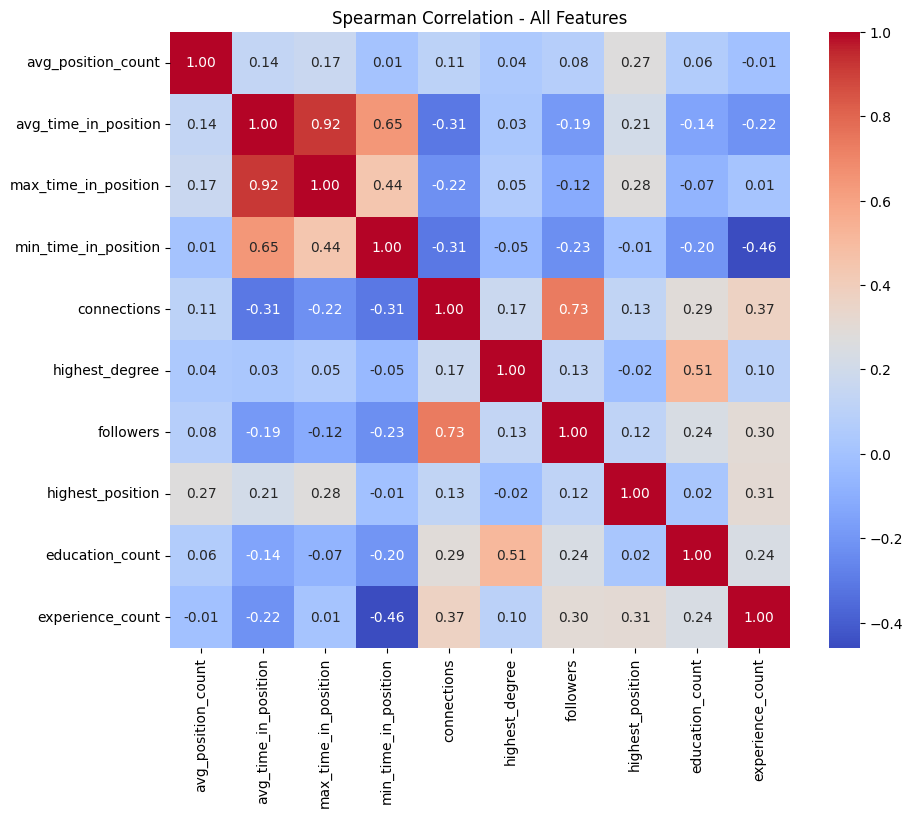

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filtered_df_pandas = filtered_all_df.toPandas()
# Pearson correlation (default)
# correlation_matrix = filtered_df_pandas.corr()

# # For Kendall correlation
# kendall_corr = filtered_df_pandas.corr(method='kendall')

# For Spearman correlation
spearman_corr = filtered_df_pandas.corr(method='spearman')

# Using seaborn's heatmap function to visualize the correlation matrix
plt.figure(figsize=(10,8))
plt.title("Spearman Correlation - All Features")
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()


# Fine-Tuning with optimal number of clusters (k=4)

In [15]:
# Duplicated code from cell above, easier to run during fine-tuning
from pyspark.sql.functions import col, udf, max as spark_max, array_max, array_min, mean
from pyspark.sql import functions as F

def add_up_all_values(values):
    if not values:
        return 0
    total = 0
    for v in values:
        if v is not None:
            total += v
    return total

add_up_all_values_udf = F.udf(add_up_all_values, IntegerType())

# reduction #1: Remove followers
# 'Reduction # 2 : max_time_in_position', 'min_time_in_position', 'max_positions', 'min_positions','avg_position_level','degree_total_sum',
selected_features = [
    'avg_num_positions_at_job',
    'connections', 'highest_degree', 'highest_position',
    'experience_count', 'position_total_sum', 'education_count'
]
# 'avg_time_in_position', removed
# , 'bs_school_name', 'ms_school_name', 'phd_school_name'
feature_cols = [*selected_features]
feature_cols_w_index = [*selected_features,'bs_school_name_index', 'ms_school_name_index',
                        'phd_school_name_index']
print(f"Total Count Before: {transformed_df.count()}")
print(f"Selected Features: {feature_cols}")
print(f"Selected Features (index): {feature_cols_w_index}")

# 'director/vp': 9,'ceo/founder/president': 10,
zero_conditions = [F.when(F.col(c) == 0, 1).otherwise(0) for c in feature_cols]
transformed_df_2 = transformed_df\
    .withColumn("highest_degree", array_max("degree_levels"))\
    .withColumn("highest_position", array_max("position_levels"))\
    .withColumn("degree_total_sum", add_up_all_values_udf("degree_levels"))\
    .withColumn("position_total_sum", add_up_all_values_udf("position_levels"))\
    .withColumn("max_time_in_position", array_max("months_in_position"))\
    .withColumn("min_time_in_position", array_min("months_in_position"))\
    .withColumn("avg_time_in_position", get_average_of_list_udf("months_in_position"))\
    .withColumn("avg_num_positions_at_job", get_average_of_list_udf("position_count"))\
    .withColumn("max_num_positions_at_job", array_max("position_count"))\
    .withColumn("min_num_positions_at_job", array_min("position_count"))\
    .withColumn("avg_position_level", get_average_of_list_udf("position_levels"))

print(f"Total Count: {transformed_df_2.count()}")
transformed_df_2.toPandas().head()


Total Count Before: 3326
Selected Features: ['avg_num_positions_at_job', 'connections', 'highest_degree', 'highest_position', 'experience_count', 'position_total_sum', 'education_count']
Selected Features (index): ['avg_num_positions_at_job', 'connections', 'highest_degree', 'highest_position', 'experience_count', 'position_total_sum', 'education_count', 'bs_school_name_index', 'ms_school_name_index', 'phd_school_name_index']
Total Count: 3326


24/04/25 17:08:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,education_count,experience_count,id,skills_count,followers,degree_levels,school_names,bs_school_name,ms_school_name,phd_school_name,...,highest_position,degree_total_sum,position_total_sum,max_time_in_position,min_time_in_position,avg_time_in_position,avg_num_positions_at_job,max_num_positions_at_job,min_num_positions_at_job,avg_position_level
0,3,17,e380dd9b-96d5-dc37-9748-e27ddf92e329,0,725,"[6, 4, 1]","[None, None, None]",None,None,None,...,9.0,11,48,56.0,2.0,13.736842,1.117647,3.0,1.0,2.526316
1,4,13,8ba35d46-21dc-f6bf-5d41-576d1f187003,0,1000,"[5, 4, 0, None]","[None, None, None, None]",None,None,None,...,11.0,9,57,21.0,3.0,6.062500,1.230769,4.0,1.0,3.562500
2,4,8,ff31aa7e-7682-74ec-6dbe-8f6348ebfbb8,0,886,"[6, 5, 4, 6]","[columbia university, None, None, columbia uni...",None,None,columbia university,...,9.0,21,18,60.0,0.0,22.727272,1.375000,3.0,1.0,1.636364
3,4,18,7657427a-3bc6-bda4-55dc-2c522bd2cf45,0,0,"[5, 4, 2, 1]","[yale, None, None, None]",None,yale,None,...,9.0,12,69,46.0,2.0,9.857142,1.166667,2.0,1.0,3.285714
4,1,18,01c697ec-5f1f-4712-8ece-2107ac3be81e,0,2000,[0],[None],None,None,None,...,6.0,0,6,312.0,9.0,58.052631,1.055556,2.0,1.0,0.315789


In [16]:
# Filter out any degree or position that is 0 (aka None or not cleaned properly so fallsback to 0)
default_values = {c:0 for c in feature_cols}
filtered_df = transformed_df_2.fillna(default_values)
filtered_df = filtered_df.select(*feature_cols)\
    .filter((F.col('highest_degree') != 0) | (F.col('highest_position') != 0))\
    .drop("id")
filtered_df_pandas = filtered_df.toPandas()
filtered_df_pandas.head()


,avg_num_positions_at_job,connections,highest_degree,highest_position,experience_count,position_total_sum,education_count
0,1.117647,500,6,9,17,48,3
1,1.230769,500,5,11,13,57,4
2,1.375000,500,6,9,8,18,4
3,1.166667,500,5,9,18,69,4
4,1.055556,500,0,6,18,6,1


## Visualize Correlation of New and Reduced Features

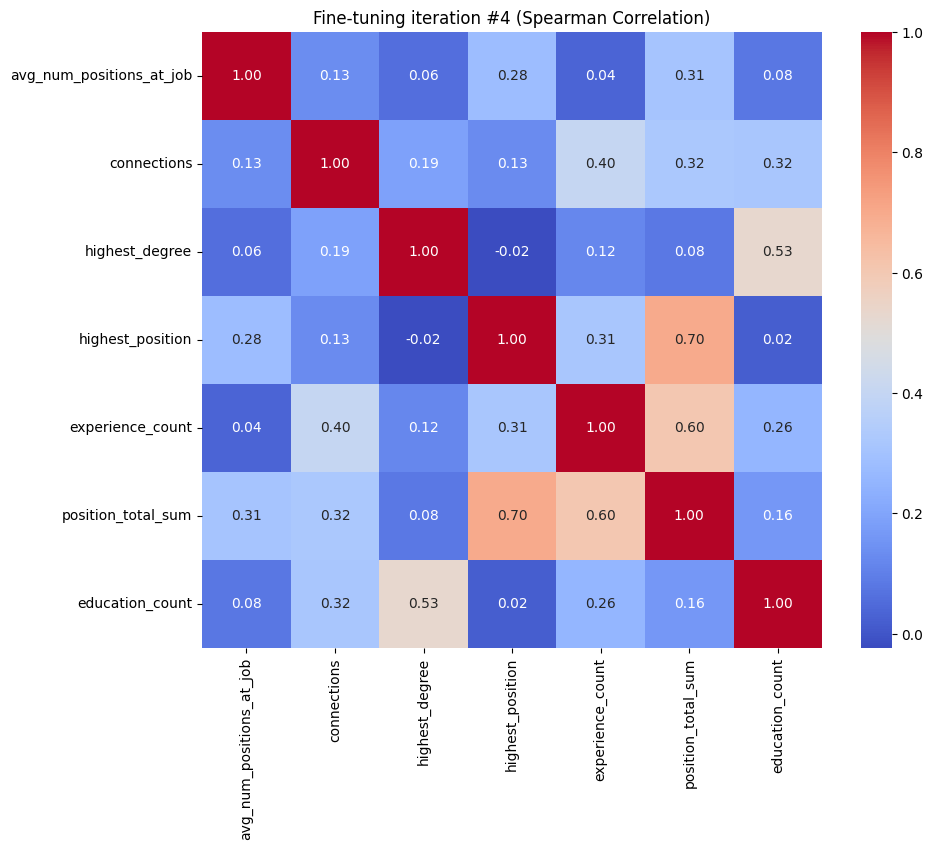

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filtered_df_pandas = filtered_df.toPandas()
filtered_df_pandas.head()
# For Spearman correlation
spearman_corr = filtered_df_pandas.corr(method='spearman')

plt.figure(figsize=(10,8))
plt.title(f"Fine-tuning iteration #4 (Spearman Correlation)")
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()


### Training Model (All values of k w/ feature reduction)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler

logger.info("Feature Cols", count=filtered_df, feature_cols=feature_cols)
assembler = VectorAssembler(
    inputCols= feature_cols,
    outputCol="features",
    handleInvalid='keep'
)

# Initialize the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
cost = []
k=4
k_means_range = range(2, 10)
for k in k_means_range:
    df_vector = assembler.transform(filtered_df)
    # Fit the scaler on the DataFrame and transform the column
    scaler_model = scaler.fit(df_vector)
    df_scaled = scaler_model.transform(df_vector)
    print(f"Training model k-means (k={k})")
    num_clusters = k
    # Train KMeans model
    kmeans = KMeans(k=num_clusters)
    model = kmeans.fit(df_vector)

    # Predict cluster assignments
    predictions = model.transform(df_vector)
    preditions_pd_df = predictions.toPandas()
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
    acc = evaluator.evaluate(predictions)
    cost.append(model.summary.trainingCost)
    print(f"Accuracy (Euclidean distance squared) -- accuracy={acc}")
    print("-------")

plt.figure(figsize=(10, 6))
plt.plot(k_means_range, cost, marker='o')
plt.title('Elbow Curve for KMeans Clustering')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost')
plt.xticks(k_means_range)
plt.grid(True)
plt.show()


### Train w/k=4

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler

logger.info("Feature Columns", feature_cols=feature_cols)

assembler = VectorAssembler(
    inputCols= feature_cols,
    outputCol="features",
    handleInvalid='keep'
)

# Initialize the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
cost = []
k = 4
df_vector = assembler.transform(filtered_df)
# Fit the scaler on the DataFrame and transform the column
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)
print(f"Training model k-means (k={k})")
num_clusters = k
# Train KMeans model
kmeans = KMeans(k=num_clusters)
model = kmeans.fit(df_vector)

# Predict cluster assignments
predictions = model.transform(df_vector)
preditions_pd_df = predictions.toPandas()
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
acc = evaluator.evaluate(predictions)
cost.append(model.summary.trainingCost)
print(f"Accuracy (Euclidean distance squared) -- accuracy={acc}")
print("-------")


2024-04-25 17:08:37 [info     ] Feature Columns                feature_cols=['avg_num_positions_at_job', 'connections', 'highest_degree', 'highest_position', 'experience_count', 'position_total_sum', 'education_count']


Training model k-means (k=4)


24/04/25 17:08:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/25 17:08:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Accuracy (Euclidean distance squared) -- accuracy=0.8086177484100906
-------


In [ ]:
# # Loads in the prediction pd df to a csv
# latest_file = f"../data/predictions_k={k}_latest.csv"
# preditions_pd_df.to_csv(latest_file, index=False)
# preditions_pd_df.head()

In [ ]:
# # Loads in the prediction pd df from a csv
# k=4
# latest_file = f"../data/predictions_k={k}_lastest.csv"

# predictions_pd_df = pd.read_csv(latest_file)
# predictions_pd_df.head()

### Show cluster plots

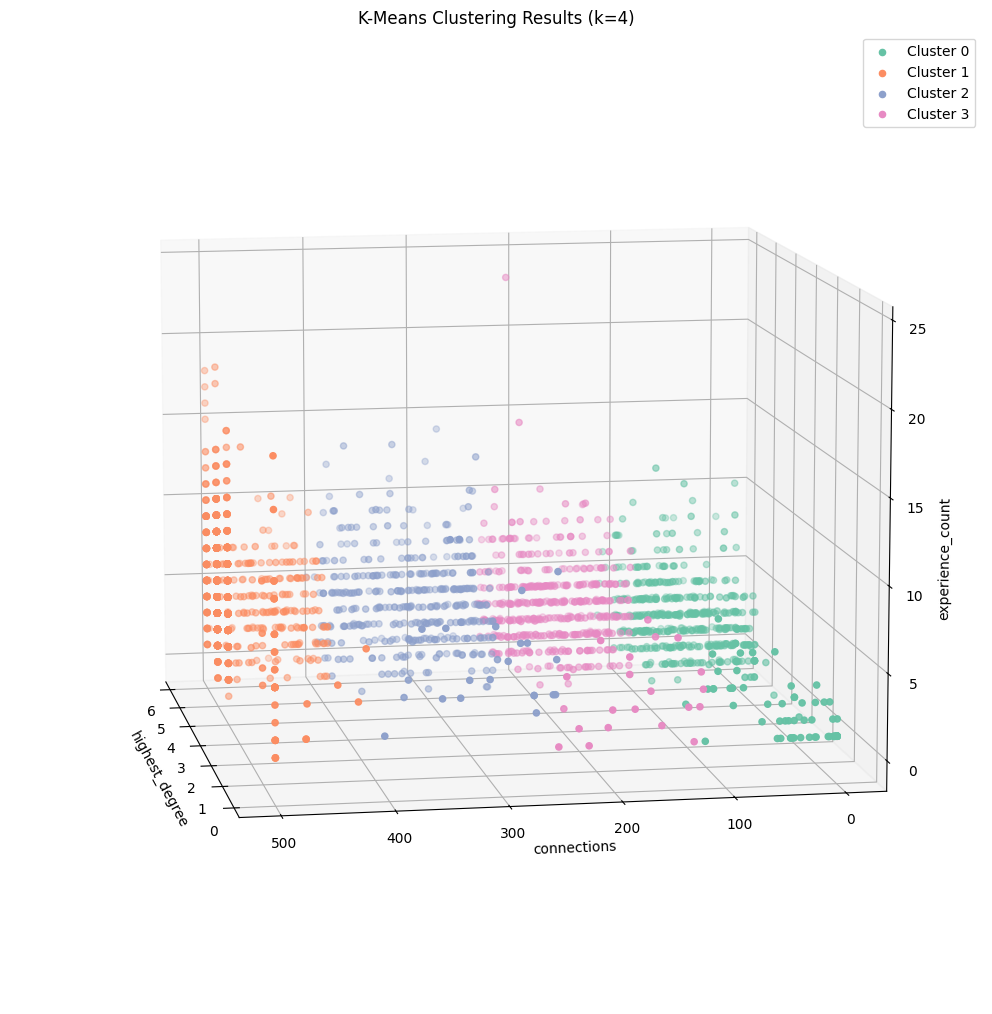

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

z = 'experience_count'
y = 'connections'
x = "highest_degree"

colors = sns.color_palette("Set2", k)

def plot_3d_clusters(predictions_df, title, k):
    '''
    Helper function to plot the 3D clusters using a DataFrame.

    Parameters:
    predictions_df - Pandas DataFrame with columns for each feature
    title - String, the title of the plot
    k - Int, number of clusters
    '''
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster using DataFrame methods
    for i in range(k):
        cluster_data = predictions_df[predictions_df['prediction'] == i]
        ax.scatter(cluster_data[x], cluster_data[y], cluster_data[z], label=f'Cluster {i}', color=colors[i])
    plt.tight_layout(pad=1.0)

    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.view_init(elev=10, azim=170)
    ax.legend()
    plt.show()
title = f'K-Means Clustering Results (k={k})'
plot_3d_clusters(preditions_pd_df, title, k)



In [37]:
import plotly.graph_objects as go
import nbformat
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# position_total_sum
position_levels_of_interest = [5, 6, 7, 8, 9, 10]
y = 'experience_count'
z = 'highest_position'
x = 'connections'
# y = "highest_position"
colors = sns.color_palette("Set2", k)
grey = "#b3b3b3"
colors = ["#66c2a5", "#fc8d62", "#8da0cb", '#e78ac3', "#a6d854", "#ff7f00", "#e5c494"]

green = "#66c2a5" # bachelors and lower
custom_data_map = {
    "highest_position": {
        5: ("intern", "#66c2a5"), # intern
        # 6: ("entry level", "#a6d854"), # entry level,
        # 7: ("midlevel", "#8da0cb"), # midlevel
        # 8: ("senior", '#66c2a5'), # senior,
        9: ("lead/manager", "#fc8d62"), # director/vp
        10: ("director/vp", "#fc8d62"), # director/vp
        11: ("ceo/founder/president", "#8da0cb") # ceo/founder/president
    },
    "highest_degree": {
        # Bachelors degree or lower
        2: ("certificate", green), # certificate
        3: ("associate", green), # associate
        4: ("bachelor", green), # bachelor

        5: ("master", "#fc8d62"), # master,
        6: ("PhD", '#fc8d62'), # PhD
    }
}

def _get_custom_color(custom_label, d):
    found_match = custom_data_map[custom_label].get(d)
    if found_match:
        return found_match[1]
    return grey

def _get_custom_label(custom_label, d):
    found_match = custom_data_map[custom_label].get(d)
    if found_match:
        return found_match[0]
    return grey


def _get_custom_label_map(custom_label, d):
    if custom_label == "highest_degree":
        mapping = job_level_mapping_to_string.get(d)

    if mapping:
        return mapping
    return d

def plotly_interactive_3d_clusters(predictions_df, title, k):
    '''
    Helper function to plot the 3D clusters using a DataFrame.

    Parameters:
    predictions_df - Pandas DataFrame with columns for each feature
    title - String, the title of the plot
    k - Int, number of clusters
    '''
    fig = go.Figure()
    # Plot each cluster using DataFrame methods
    for i in range(k):
        cluster_data = predictions_df[predictions_df['prediction'] == i]
        # custom_label = "highest_degree"
        custom_label = "highest_degree"
        cluster_data[custom_label] = cluster_data[custom_label].astype(int)
        # ax.scatter(cluster_data[x], cluster_data[y], cluster_data[z], label=f'Cluster {i}', color=colors[i])
        fig.add_trace(go.Scatter3d(
            x=cluster_data[x],
            y=cluster_data[y],
            z=cluster_data[z],
            customdata=cluster_data[custom_label],
            hovertemplate=(
            f'<b>Cluster {i}</b><br>'
            f'<b>{x}</b> %{{x}}<br>'
            f'<b>{y}</b> %{{y}}<br>'
            f'<b>{z}</b> %{{z}}<br>'
            f'<b>{custom_label}</b> %{{customdata}}<br>'
            f'<extra></extra>'
            ),
            mode='markers',
            marker=dict(
                size=3,
                line=dict(
                    width=0
                ),
                # color=colors[i],
                color=[_get_custom_color(custom_label, d) for d in cluster_data[custom_label]],
                opacity=0.7
            ),
            name=f'Cluster {i}'
        ))

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis=dict(title=x, title_font=dict(size=10), tickfont=dict(size=8)),
            yaxis=dict(title=y, title_font=dict(size=10), tickfont=dict(size=8), range=[1, 25]),
            zaxis=dict(title=z, title_font=dict(size=10), tickfont=dict(size=8)),
        ),
        legend=dict(
            title=dict(text='Cluster'),
            font=dict(
                size=12
            ),
            itemwidth=30
        ),
    )

    plt.tight_layout(pad=1.0)
    fig.show()
preditions_pd_df = preditions_pd_df[preditions_pd_df['highest_degree'] != 0]
preditions_pd_df = preditions_pd_df[preditions_pd_df['highest_position'] != 0]
title = f'K-Means Clustering Results (k={k})'
plotly_interactive_3d_clusters(preditions_pd_df, title, k)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Loads in the prediction pd df from a csv
k=4
predictions_pd_df_with_edu = pd.read_csv(f"../data/predictions_k={k}_with_education_count.csv")
predictions_pd_df_with_edu.head()

In [35]:
higher_education = preditions_pd_df[preditions_pd_df['highest_degree'] > 4]
print(f"higher count {higher_education.count()}")
bachelor_or_lower = preditions_pd_df[preditions_pd_df['highest_degree'] <= 4]
print(f"bachelor_or_lower count {bachelor_or_lower.count()}")

higher count avg_num_positions_at_job    1411
connections                 1411
highest_degree              1411
highest_position            1411
experience_count            1411
position_total_sum          1411
education_count             1411
features                    1411
prediction                  1411
dtype: int64
bachelor_or_lower count avg_num_positions_at_job    848
connections                 848
highest_degree              848
highest_position            848
experience_count            848
position_total_sum          848
education_count             848
features                    848
prediction                  848
dtype: int64


### Add String Indexer for School Names

In [ ]:
from collections import defaultdict
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
# Create a StringIndexers
school_name_cols = ['bs_school_name', 'ms_school_name', 'phd_school_name']
indexers = [
    StringIndexer(
        inputCol=column,
        outputCol=column + "_index"
    ) for column in school_name_cols
]
# configure the pipeline with school name indexers
pipeline = Pipeline(stages=indexers)
pipeline_model = pipeline.fit(filtered_df)
filtered_df = pipeline_model.transform(filtered_df)
filtered_df = filtered_df.drop(*school_name_cols)
logger.info("Successfully filtered df", size=filtered_df.count())

school_name_mapping = defaultdict(int)
# Retrieve and print the mappings for each column
for i, column in enumerate(school_name_cols):
    string_indexer_model = pipeline_model.stages[i]
    for j, label in enumerate(string_indexer_model.labels):
        school_name_mapping[label] += 1

sorted_school_names = dict(sorted(school_name_mapping.items(), key=lambda item: item[1]))
print(f"Length of school name mapping: {len(sorted_school_names)}")
print(sorted_school_names)
pandas_df = filtered_df.toPandas()
pandas_df.head()

In [ ]:
# import plotly.graph_objects as go
# import nbformat
# import pandas as pd
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns

# colors = sns.color_palette("Set2", k)
# colors = ["#66c2a5", "#fc8d62", "#8da0cb", '#e78ac3']
# def plotly_interactive_3d_clusters(predictions_df, title, k):
#     '''
#     Helper function to plot the 3D clusters using a DataFrame.

#     Parameters:
#     predictions_df - Pandas DataFrame with columns for each feature
#     title - String, the title of the plot
#     k - Int, number of clusters
#     '''
#     fig = go.Figure()

#     # Plot each cluster using DataFrame methods
#     for i in range(k):
#         cluster_data = predictions_df[predictions_df['prediction'] == i]
#         fig.add_trace(go.Scatter3d(
#             x=cluster_data[x],
#             y=cluster_data[y],
#             z=cluster_data[z],
#             hovertemplate=(
#             f'<b>{x}</b> %{{x}}<br>'
#             f'<b>{y}</b> %{{y}}<br>'
#             f'<b>{z}</b> %{{z}}<br>'
#             f'<extra></extra>'
#             ),
#             mode='markers',
#             marker=dict(
#                 size=2,
#                 line=dict(
#                     width=0
#                 ),
#                 color=colors[i],
#                 opacity=0.7
#             ),
#             name=f'Cluster {i}'
#         ))

#     fig.update_layout(
#         margin=dict(l=0, r=0, b=0, t=0),
#         scene=dict(
#             xaxis=dict(title=x, title_font=dict(size=10), tickfont=dict(size=8)),
#             yaxis=dict(title=y, title_font=dict(size=10), tickfont=dict(size=8)),
#             zaxis=dict(title=z, title_font=dict(size=10), tickfont=dict(size=8)),
#         ),
#         legend=dict(
#             title=dict(text='Cluster'),
#             font=dict(
#                 size=10
#             )
#         ),
#     )

#     plt.tight_layout(pad=1.0)
#     fig.show()


In [ ]:
spark.stop()
# Delete tmp directory
shutil.rmtree(temp_dir)
logger.info('successfully stopped spark and remove tmp dir')